# ARIMA in Crude Oil, Gasoline RBOB, Heating Oil

### Các thư viện cần thiết

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
!pip install pmdarima

   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
    --------------------------------------- 10.2/614.7 kB ? eta -:--:--
   - ------------------------------------- 30.7/614.7 kB 330.3 kB/s eta 0:00:02
   ---- ---------------------------------- 71.7/614.7 kB 491.5 kB/s eta 0:00:02
   ------------- -------------------------- 215.0/614.7 kB 1.2 MB/s eta 0:00:01
   ---------------------- ----------------- 348.2/614.7 kB 1.7 MB/s eta 0:00:01
   --------------------------------- ------ 522.2/614.7 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB 5.4 MB/s eta 0:00:01
   ---- ----------------------------------- 0.3/2.8 MB 4.6 MB/s eta 0:00:01
   --------- ------------------------------ 0.7/2.8 MB 5.2 MB/s eta 0:00:01
   ------

In [4]:
from pmdarima.arima import auto_arima

# Train-Test 7:3

# Crude Oil WTI - 7:3

In [5]:
# Đọc file dữ liệu và loại bỏ những dòng bị thiếu
df= pd.read_csv('Crude Oil WTI Futures Historical Data.csv')
df = df.dropna() # Drop missing values

In [6]:
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,27-03-2024,81.35,81.29,81.74,80.55,249960,-0.33
1,26-03-2024,81.62,81.94,82.36,81.22,235850,-0.40
2,25-03-2024,81.95,80.85,82.48,80.59,300360,1.64
3,22-03-2024,80.63,80.84,81.45,80.42,231100,-0.54
4,21-03-2024,81.07,81.49,81.92,80.30,266860,-0.75
...,...,...,...,...,...,...,...
1379,08-01-2019,49.78,48.73,49.95,48.31,765980,2.60
1380,07-01-2019,48.52,48.30,49.79,48.11,819940,1.17
1381,04-01-2019,47.96,46.90,49.22,46.65,817280,1.85
1382,03-01-2019,47.09,46.26,47.49,45.35,788720,1.18


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 0 to 1383
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1296 non-null   object 
 1   Price     1296 non-null   float64
 2   Open      1296 non-null   float64
 3   High      1296 non-null   float64
 4   Low       1296 non-null   float64
 5   Vol.      1296 non-null   int64  
 6   Change %  1296 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 81.0+ KB


In [38]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [9]:
# Tách dữ liệu train-test 7:3
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [10]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [11]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3825.174, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3843.512, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3845.478, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3845.472, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3841.959, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3839.933, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3840.073, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3827.611, Time=2.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3827.978, Time=1.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3841.596, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3842.781, Time=0.61 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3843.481, Time=0.47 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3823.656, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
# Testing model 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [13]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

Predict closing prices for the next 30 days:
[40.82433112 40.93543674 40.92543466 40.81608101 40.82190048 40.92938287
 40.92759798 40.82209849 40.81999806 40.9234106  40.92924614 40.82801713
 40.81859737 40.91755361 40.93040632 40.83380487 40.81767058 40.91184232
 40.93110696 40.83943291 40.81718874 40.90630393 40.93137743 40.84487563
 40.81712212 40.90096248 40.9312478  40.85011057 40.81744038 40.89583892]


- Calculate Error Values -
MAE:  14.65452598574906
MAPE:  33.42757365588305
RMSE:  16.11868110728755


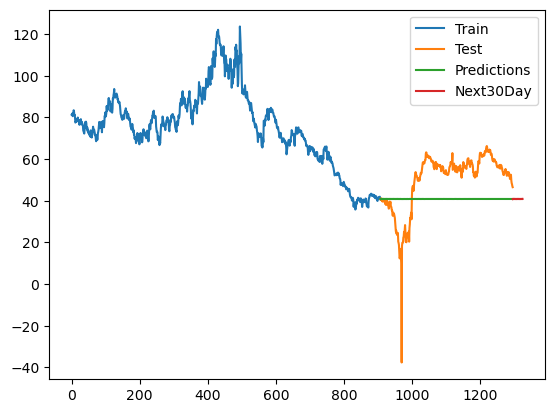

In [14]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

# Gasoline RBOB - 7:3

In [25]:
# Đọc file dữ liệu, loại bỏ những dòng bị thiếu và chuẩn hóa dữ liệu
df= pd.read_csv('Gasoline RBOB Futures Historical Data.csv')
df = df.dropna() # Drop missing values

In [26]:
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,27-03-2024,2.6847,2.6878,2.6976,2.6877,150,-0.59
1,26-03-2024,2.7006,2.7489,2.7500,2.6980,390,-1.74
2,25-03-2024,2.7484,2.7370,2.7603,2.7310,620,1.11
4,22-03-2024,2.7398,2.7090,2.7456,2.7090,610,0.47
5,21-03-2024,2.7271,2.7370,2.7376,2.7119,150,-0.22
...,...,...,...,...,...,...,...
1616,08-01-2019,1.4740,1.3466,1.3722,1.3385,74920,1.62
1617,07-01-2019,1.4505,1.3560,1.3945,1.3389,79090,5.95
1619,04-01-2019,1.4515,1.3364,1.3981,1.3293,66360,0.96
1620,03-01-2019,1.4377,1.3160,1.3676,1.3016,57750,1.60


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1330 entries, 0 to 1621
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1330 non-null   object 
 1   Price     1330 non-null   float64
 2   Open      1330 non-null   float64
 3   High      1330 non-null   float64
 4   Low       1330 non-null   float64
 5   Vol.      1330 non-null   int64  
 6   Change %  1330 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 83.1+ KB


In [28]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [29]:
# Tách dữ liệu train-test 7:3
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [30]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [31]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2301.012, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2228.799, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2274.657, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2294.386, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2230.366, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2303.154, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2304.985, Time=0.43 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2303.240, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2304.859, Time=0.78 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2301.262, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2305.674, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2295.392, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2303.844, Time=0.43 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-2303.878, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [32]:
# Testing model 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [33]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

Predict closing prices for the next 30 days:
[1.22822927 1.22936476 1.22936476 1.22936476 1.22936476 1.22936476
 1.22936476 1.22936476 1.22936476 1.22936476 1.22936476 1.22936476
 1.22936476 1.22936476 1.22936476 1.22936476 1.22936476 1.22936476
 1.22936476 1.22936476 1.22936476 1.22936476 1.22936476 1.22936476
 1.22936476 1.22936476 1.22936476 1.22936476 1.22936476 1.22936476]


- Calculate Error Values -
MAE:  0.21193025484653139
MAPE:  15.74001455464006
RMSE:  0.23301793399593893


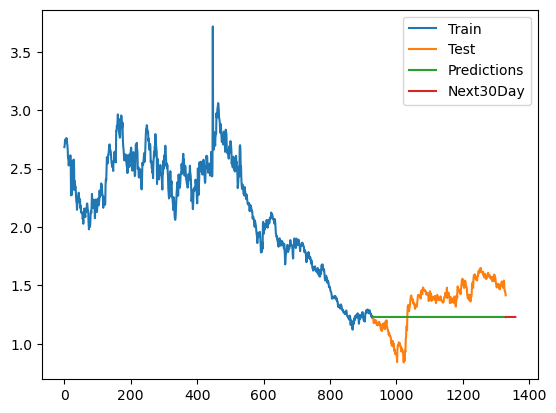

In [34]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

# Heating Oil - 7:3

In [35]:
# Đọc file dữ liệu, loại bỏ những dòng bị thiếu và chuẩn hóa dữ liệu
df= pd.read_csv('Heating Oil Futures Historical Data.csv')
df = df.dropna() # Drop missing values

In [36]:
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,27-03-2024,2.5986,2.6109,2.6172,2.5884,20970,-0.88
1,26-03-2024,2.6218,2.6845,2.6870,2.6097,24090,-2.12
2,25-03-2024,2.6786,2.6644,2.7062,2.6533,29060,0.95
3,22-03-2024,2.6534,2.6630,2.6904,2.6471,27590,-0.58
4,21-03-2024,2.6688,2.6932,2.7026,2.6360,24850,-1.00
...,...,...,...,...,...,...,...
1377,08-01-2019,1.8270,1.7810,1.8296,1.7757,57590,2.73
1378,07-01-2019,1.7784,1.7809,1.8245,1.7764,57180,0.52
1379,04-01-2019,1.7692,1.7300,1.8035,1.7236,61140,1.56
1380,03-01-2019,1.7420,1.7008,1.7466,1.6801,56550,2.43


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1319 entries, 0 to 1381
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1319 non-null   object 
 1   Price     1319 non-null   float64
 2   Open      1319 non-null   float64
 3   High      1319 non-null   float64
 4   Low       1319 non-null   float64
 5   Vol.      1319 non-null   int64  
 6   Change %  1319 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 82.4+ KB


In [38]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [39]:
# Tách dữ liệu train-test 7:3
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [40]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [41]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1820.590, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1793.474, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1804.862, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1806.114, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1795.238, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1806.658, Time=0.91 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1818.599, Time=1.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1817.318, Time=1.83 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1824.172, Time=1.87 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1820.488, Time=1.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1829.052, Time=1.55 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-1827.540, Time=1.78 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-1824.246, Time=1.87 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-1825.292, Time=1.72 sec
 ARIMA(4,1,2)(0,0,0

ARIMA(order=(3, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [42]:
# Testing model 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [43]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

Predict closing prices for the next 30 days:
[1.26165153 1.25780069 1.25364151 1.25569432 1.25231889 1.25227367
 1.25162809 1.25054309 1.25044934 1.24980043 1.2494943  1.2492504
 1.24894151 1.24878829 1.24860404 1.2484655  1.24836088 1.24825824
 1.24818494 1.24811929 1.24806494 1.24802199 1.24798435 1.24795438
 1.24792923 1.24790823 1.24789115 1.24787676 1.24786495 1.24785517]


- Calculate Error Values -
MAE:  0.5445877665706712
MAPE:  31.41870501907031
RMSE:  0.5952657823062707


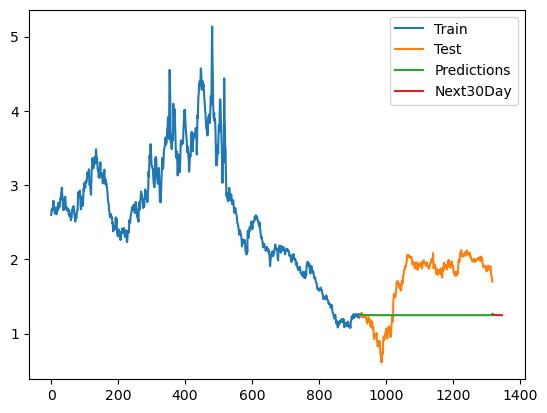

In [44]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

# Train-Test 8:2

# Crude Oil WTI - 8:2

In [45]:
# Đọc file dữ liệu và loại bỏ những dòng bị thiếu
df= pd.read_csv('Crude Oil WTI Futures Historical Data.csv')
df = df.dropna() # Drop missing values

In [46]:
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,27-03-2024,81.35,81.29,81.74,80.55,249960,-0.33
1,26-03-2024,81.62,81.94,82.36,81.22,235850,-0.40
2,25-03-2024,81.95,80.85,82.48,80.59,300360,1.64
3,22-03-2024,80.63,80.84,81.45,80.42,231100,-0.54
4,21-03-2024,81.07,81.49,81.92,80.30,266860,-0.75
...,...,...,...,...,...,...,...
1379,08-01-2019,49.78,48.73,49.95,48.31,765980,2.60
1380,07-01-2019,48.52,48.30,49.79,48.11,819940,1.17
1381,04-01-2019,47.96,46.90,49.22,46.65,817280,1.85
1382,03-01-2019,47.09,46.26,47.49,45.35,788720,1.18


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 0 to 1383
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1296 non-null   object 
 1   Price     1296 non-null   float64
 2   Open      1296 non-null   float64
 3   High      1296 non-null   float64
 4   Low       1296 non-null   float64
 5   Vol.      1296 non-null   int64  
 6   Change %  1296 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 81.0+ KB


In [48]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [49]:
# Tách dữ liệu train-test 8:2
train_size = int(0.8 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [50]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [51]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5166.405, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5241.137, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5179.268, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5165.591, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5239.193, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5162.847, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5164.397, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5164.339, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5163.628, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5169.161, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5161.000, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5163.715, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5177.362, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5162.562, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]          

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [52]:
# Testing model 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [53]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

Predict closing prices for the next 30 days:
[58.15502925 58.13732122 58.1331386  58.13215067 58.13191733 58.13186221
 58.13184919 58.13184612 58.13184539 58.13184522 58.13184518 58.13184517
 58.13184516 58.13184516 58.13184516 58.13184516 58.13184516 58.13184516
 58.13184516 58.13184516 58.13184516 58.13184516 58.13184516 58.13184516
 58.13184516 58.13184516 58.13184516 58.13184516 58.13184516 58.13184516]


- Calculate Error Values -
MAE:  3.1397021413193045
MAPE:  5.595256609740273
RMSE:  3.820444666625679


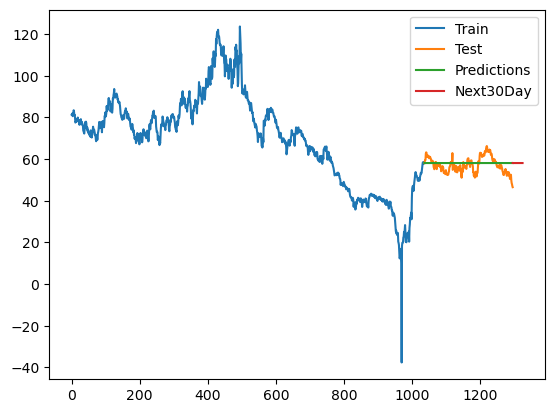

In [54]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

# Gasoline RBOB - 8:2

In [55]:
# Đọc file dữ liệu, loại bỏ những dòng bị thiếu và chuẩn hóa dữ liệu
df= pd.read_csv('Gasoline RBOB Futures Historical Data.csv')
df = df.dropna() # Drop missing values

In [56]:
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,27-03-2024,2.6847,2.6878,2.6976,2.6877,150,-0.59
1,26-03-2024,2.7006,2.7489,2.7500,2.6980,390,-1.74
2,25-03-2024,2.7484,2.7370,2.7603,2.7310,620,1.11
4,22-03-2024,2.7398,2.7090,2.7456,2.7090,610,0.47
5,21-03-2024,2.7271,2.7370,2.7376,2.7119,150,-0.22
...,...,...,...,...,...,...,...
1616,08-01-2019,1.4740,1.3466,1.3722,1.3385,74920,1.62
1617,07-01-2019,1.4505,1.3560,1.3945,1.3389,79090,5.95
1619,04-01-2019,1.4515,1.3364,1.3981,1.3293,66360,0.96
1620,03-01-2019,1.4377,1.3160,1.3676,1.3016,57750,1.60


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1330 entries, 0 to 1621
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1330 non-null   object 
 1   Price     1330 non-null   float64
 2   Open      1330 non-null   float64
 3   High      1330 non-null   float64
 4   Low       1330 non-null   float64
 5   Vol.      1330 non-null   int64  
 6   Change %  1330 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 83.1+ KB


In [58]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [59]:
# Tách dữ liệu train-test 8:2
train_size = int(0.8 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [60]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [61]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2743.103, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2666.629, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2717.194, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2736.909, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2668.283, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2744.875, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2746.822, Time=0.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2744.899, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2746.074, Time=0.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2742.905, Time=0.92 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2747.831, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2738.136, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2745.870, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-2745.889, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [62]:
# Testing model 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [63]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

Predict closing prices for the next 30 days:
[1.35397826 1.35045024 1.35045024 1.35045024 1.35045024 1.35045024
 1.35045024 1.35045024 1.35045024 1.35045024 1.35045024 1.35045024
 1.35045024 1.35045024 1.35045024 1.35045024 1.35045024 1.35045024
 1.35045024 1.35045024 1.35045024 1.35045024 1.35045024 1.35045024
 1.35045024 1.35045024 1.35045024 1.35045024 1.35045024 1.35045024]


- Calculate Error Values -
MAE:  0.12031996910033892
MAPE:  7.906009946165986
RMSE:  0.14511916327607097


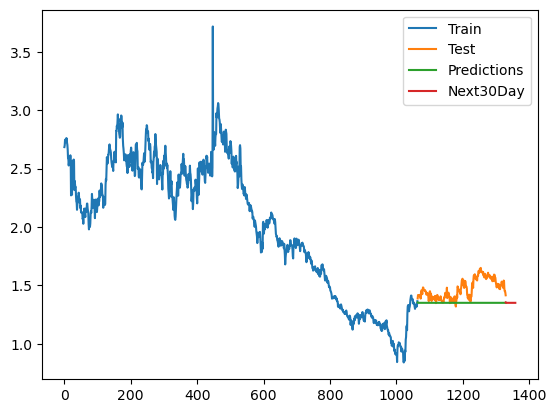

In [64]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

# Heating Oil - 8:2

In [65]:
# Đọc file dữ liệu, loại bỏ những dòng bị thiếu và chuẩn hóa dữ liệu
df= pd.read_csv('Heating Oil Futures Historical Data.csv')
df = df.dropna() # Drop missing values

In [66]:
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,27-03-2024,2.5986,2.6109,2.6172,2.5884,20970,-0.88
1,26-03-2024,2.6218,2.6845,2.6870,2.6097,24090,-2.12
2,25-03-2024,2.6786,2.6644,2.7062,2.6533,29060,0.95
3,22-03-2024,2.6534,2.6630,2.6904,2.6471,27590,-0.58
4,21-03-2024,2.6688,2.6932,2.7026,2.6360,24850,-1.00
...,...,...,...,...,...,...,...
1377,08-01-2019,1.8270,1.7810,1.8296,1.7757,57590,2.73
1378,07-01-2019,1.7784,1.7809,1.8245,1.7764,57180,0.52
1379,04-01-2019,1.7692,1.7300,1.8035,1.7236,61140,1.56
1380,03-01-2019,1.7420,1.7008,1.7466,1.6801,56550,2.43


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1319 entries, 0 to 1381
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1319 non-null   object 
 1   Price     1319 non-null   float64
 2   Open      1319 non-null   float64
 3   High      1319 non-null   float64
 4   Low       1319 non-null   float64
 5   Vol.      1319 non-null   int64  
 6   Change %  1319 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 82.4+ KB


In [68]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [69]:
# Tách dữ liệu train-test 8:2
train_size = int(0.8 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [70]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [71]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2181.074, Time=1.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2151.392, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2164.458, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2165.815, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2153.318, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2166.454, Time=0.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2177.397, Time=1.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2174.329, Time=1.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2183.238, Time=1.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2180.826, Time=1.67 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-2188.486, Time=1.81 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-2186.923, Time=2.46 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-2183.938, Time=2.13 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-2184.591, Time=2.68 sec
 ARIMA(4,1,2)(0,0,0

ARIMA(order=(3, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [72]:
# Testing model 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [73]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

Predict closing prices for the next 30 days:
[1.83224639 1.82139974 1.80977724 1.80888587 1.80098095 1.7980355
 1.79532264 1.79197724 1.79054852 1.78862401 1.78727921 1.78631107
 1.78531886 1.78467131 1.78408381 1.783605   1.78324841 1.7829311
 1.78268973 1.78249169 1.78232767 1.78219994 1.78209335 1.78200822
 1.78193967 1.78188344 1.78183858 1.781802   1.78177242 1.78174861]


- Calculate Error Values -
MAE:  0.158980663572051
MAPE:  8.03433178381279
RMSE:  0.17813671120547991


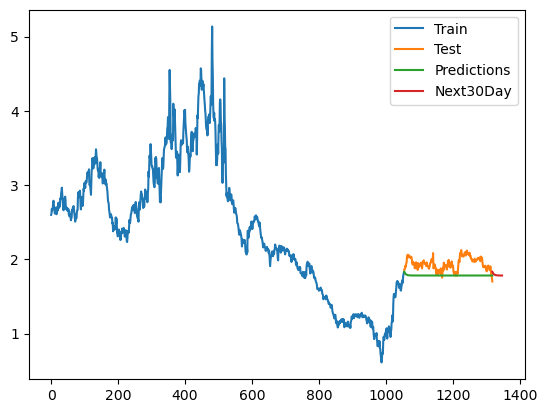

In [74]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

# Train-Test 9:1

# Crude Oil WTI - 9:1

In [75]:
# Đọc file dữ liệu và loại bỏ những dòng bị thiếu
df= pd.read_csv('Crude Oil WTI Futures Historical Data.csv')
df = df.dropna() # Drop missing values

In [76]:
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,27-03-2024,81.35,81.29,81.74,80.55,249960,-0.33
1,26-03-2024,81.62,81.94,82.36,81.22,235850,-0.40
2,25-03-2024,81.95,80.85,82.48,80.59,300360,1.64
3,22-03-2024,80.63,80.84,81.45,80.42,231100,-0.54
4,21-03-2024,81.07,81.49,81.92,80.30,266860,-0.75
...,...,...,...,...,...,...,...
1379,08-01-2019,49.78,48.73,49.95,48.31,765980,2.60
1380,07-01-2019,48.52,48.30,49.79,48.11,819940,1.17
1381,04-01-2019,47.96,46.90,49.22,46.65,817280,1.85
1382,03-01-2019,47.09,46.26,47.49,45.35,788720,1.18


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 0 to 1383
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1296 non-null   object 
 1   Price     1296 non-null   float64
 2   Open      1296 non-null   float64
 3   High      1296 non-null   float64
 4   Low       1296 non-null   float64
 5   Vol.      1296 non-null   int64  
 6   Change %  1296 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 81.0+ KB


In [78]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [79]:
# Tách dữ liệu train-test 9:1
train_size = int(0.9 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [80]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [81]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5704.935, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5788.834, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5720.827, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5705.399, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5786.879, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5702.968, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5702.439, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5703.107, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5701.435, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5702.995, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5709.048, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5699.561, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5703.498, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5718.901, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]          

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [82]:
# Testing model 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [83]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

Predict closing prices for the next 30 days:
[60.21090338 60.15629172 60.14267931 60.1392863  60.13844056 60.13822976
 60.13817721 60.13816412 60.13816085 60.13816004 60.13815983 60.13815978
 60.13815977 60.13815977 60.13815977 60.13815977 60.13815977 60.13815977
 60.13815977 60.13815977 60.13815977 60.13815977 60.13815977 60.13815977
 60.13815977 60.13815977 60.13815977 60.13815977 60.13815977 60.13815977]


- Calculate Error Values -
MAE:  4.388288638898367
MAPE:  8.00188819989623
RMSE:  5.2409578412723485


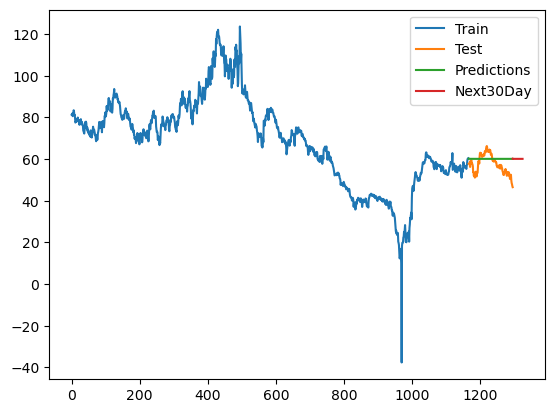

In [84]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

# Gasoline RBOB - 9:1

In [85]:
# Đọc file dữ liệu, loại bỏ những dòng bị thiếu và chuẩn hóa dữ liệu
df= pd.read_csv('Gasoline RBOB Futures Historical Data.csv')
df = df.dropna() # Drop missing values

In [86]:
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,27-03-2024,2.6847,2.6878,2.6976,2.6877,150,-0.59
1,26-03-2024,2.7006,2.7489,2.7500,2.6980,390,-1.74
2,25-03-2024,2.7484,2.7370,2.7603,2.7310,620,1.11
4,22-03-2024,2.7398,2.7090,2.7456,2.7090,610,0.47
5,21-03-2024,2.7271,2.7370,2.7376,2.7119,150,-0.22
...,...,...,...,...,...,...,...
1616,08-01-2019,1.4740,1.3466,1.3722,1.3385,74920,1.62
1617,07-01-2019,1.4505,1.3560,1.3945,1.3389,79090,5.95
1619,04-01-2019,1.4515,1.3364,1.3981,1.3293,66360,0.96
1620,03-01-2019,1.4377,1.3160,1.3676,1.3016,57750,1.60


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1330 entries, 0 to 1621
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1330 non-null   object 
 1   Price     1330 non-null   float64
 2   Open      1330 non-null   float64
 3   High      1330 non-null   float64
 4   Low       1330 non-null   float64
 5   Vol.      1330 non-null   int64  
 6   Change %  1330 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 83.1+ KB


In [88]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [89]:
# Tách dữ liệu train-test 9:1
train_size = int(0.9 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [90]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [91]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3209.646, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3124.606, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3180.533, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3202.153, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3126.340, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3211.828, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3213.734, Time=0.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3211.867, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3212.986, Time=1.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3209.889, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3214.965, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3203.559, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3213.043, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-3213.077, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [92]:
# Testing model 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [93]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

Predict closing prices for the next 30 days:
[1.50322192 1.49827472 1.49827472 1.49827472 1.49827472 1.49827472
 1.49827472 1.49827472 1.49827472 1.49827472 1.49827472 1.49827472
 1.49827472 1.49827472 1.49827472 1.49827472 1.49827472 1.49827472
 1.49827472 1.49827472 1.49827472 1.49827472 1.49827472 1.49827472
 1.49827472 1.49827472 1.49827472 1.49827472 1.49827472 1.49827472]


- Calculate Error Values -
MAE:  0.06174282832143775
MAPE:  3.9993901747143736
RMSE:  0.07330806543302511


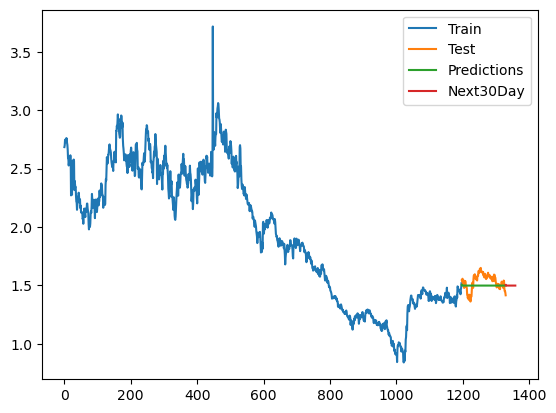

In [94]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

# Heating Oil - 9:1

In [95]:
# Đọc file dữ liệu, loại bỏ những dòng bị thiếu và chuẩn hóa dữ liệu
df= pd.read_csv('Heating Oil Futures Historical Data.csv')
df = df.dropna() # Drop missing values

In [96]:
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,27-03-2024,2.5986,2.6109,2.6172,2.5884,20970,-0.88
1,26-03-2024,2.6218,2.6845,2.6870,2.6097,24090,-2.12
2,25-03-2024,2.6786,2.6644,2.7062,2.6533,29060,0.95
3,22-03-2024,2.6534,2.6630,2.6904,2.6471,27590,-0.58
4,21-03-2024,2.6688,2.6932,2.7026,2.6360,24850,-1.00
...,...,...,...,...,...,...,...
1377,08-01-2019,1.8270,1.7810,1.8296,1.7757,57590,2.73
1378,07-01-2019,1.7784,1.7809,1.8245,1.7764,57180,0.52
1379,04-01-2019,1.7692,1.7300,1.8035,1.7236,61140,1.56
1380,03-01-2019,1.7420,1.7008,1.7466,1.6801,56550,2.43


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1319 entries, 0 to 1381
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1319 non-null   object 
 1   Price     1319 non-null   float64
 2   Open      1319 non-null   float64
 3   High      1319 non-null   float64
 4   Low       1319 non-null   float64
 5   Vol.      1319 non-null   int64  
 6   Change %  1319 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 82.4+ KB


In [98]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [99]:
# Tách dữ liệu train-test 9:1
train_size = int(0.9 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [100]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [101]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2569.588, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2538.496, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2552.071, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2553.488, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2540.449, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2554.192, Time=0.89 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2566.364, Time=1.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2561.749, Time=1.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2572.673, Time=2.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2569.890, Time=1.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-2577.427, Time=2.69 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-2576.613, Time=2.38 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-2573.320, Time=2.41 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-2574.184, Time=2.22 sec
 ARIMA(4,1,2)(0,0,0

ARIMA(order=(3, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [102]:
# Testing model 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [103]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

Predict closing prices for the next 30 days:
[1.98183126 1.97345147 1.96961258 1.96751987 1.96355436 1.96206904
 1.9600571  1.9584661  1.95743257 1.95630166 1.95554281 1.95487487
 1.9543052  1.95387985 1.95350089 1.95320369 1.95296011 1.95275556
 1.95259313 1.9524573  1.95234678 1.95225676 1.9521823  1.95212187
 1.95207218 1.95203148 1.95199825 1.95197095 1.95194865 1.95193038]


- Calculate Error Values -
MAE:  0.08031257456740354
MAPE:  4.133209002975269
RMSE:  0.09426010201012178


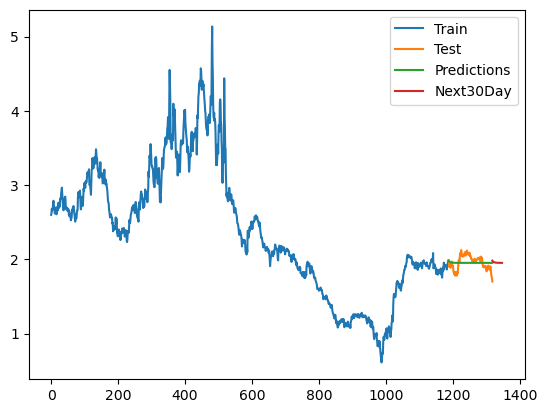

In [104]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()